# Plot subhalos

In [2]:
import sys, os
sys.path.append('../')

import logging
import numpy as np
import matplotlib.pyplot as plt

logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

## Make data

In [23]:
def _extract_n_subs(latents):
    return np.array([v[0] for v in latents])


def _extract_heaviest_subs(latents, n=100):
    all_masses = []
    for v in latents:
        masses = np.zeros(n)
        masses[:len(masses)] = list(sorted(v[1], reverse=True))[:n]
        all_masses.append(masses)
    return np.array(all_masses)


def _extract_all_m_subs(latents):
    return [np.array(v[1]) for v in latents]


def _extract_sum_m_subs(latents):
    return np.array([np.sum(v[1]) for v in latents])


def _extract_pos_subs(latents):
    return [np.array((v[2], v[3])).T for v in latents]


In [24]:
def simulate_train(n=1000, n_prior_samples=1000, alpha_mean=10., alpha_std=2., beta_mean=-1.9, beta_std=0.2,
                   m_sub_min=10.):
    alpha_train = np.random.normal(loc=alpha_mean, scale=alpha_std, size=n // 2)
    beta_train = np.random.normal(loc=beta_mean, scale=beta_std, size=n // 2)
    theta_train = np.vstack((alpha_train, beta_train)).T
    assert np.min(alpha_train) > 0.
    assert np.max(beta_train) < -1.

    sim = SubhaloSimulator(
        m_sub_min=m_sub_min,
        m_sub_high=m_sub_min
    )

    y0 = np.zeros(n // 2)
    x0, t_xz0, log_r_xz0, log_r_xz_uncertainties0, latents0 = sim.rvs_score_ratio_to_evidence(
        alpha_train,
        beta_train,
        alpha_mean,
        alpha_std,
        beta_mean,
        beta_std,
        n // 2,
        n_prior_samples
    )
    m_subs0 = _extract_all_m_subs(latents0)
    n_subs0 = _extract_n_subs(latents0)
    pos_subs0 = _extract_pos_subs(latents0)

    y1 = np.ones(n // 2)
    x1, t_xz1, log_r_xz1, log_r_xz_uncertainties1, latents1 = sim.rvs_score_ratio_to_evidence_inverse(
        alpha_train,
        beta_train,
        alpha_mean,
        alpha_std,
        beta_mean,
        beta_std,
        n // 2,
        n_prior_samples
    )
    m_subs1 = _extract_all_m_subs(latents1)
    n_subs1 = _extract_n_subs(latents1)
    pos_subs1 = _extract_pos_subs(latents1)

    x = np.vstack((x0, x1))
    y = np.hstack((y0, y1))
    theta = np.vstack((theta_train, theta_train))
    t_xz = np.vstack((t_xz0, t_xz1))
    log_r_xz = np.hstack((log_r_xz0, log_r_xz1))
    r_xz = np.exp(log_r_xz, dtype=np.float64)
    n_subs = np.hstack((n_subs0, n_subs1))
    m_subs = m_subs0 + m_subs1
    pos_subs = pos_subs0 + pos_subs1

    return x, y, theta, r_xz, t_xz, n_subs, m_subs, pos_subs

In [35]:
x, y, theta, r_xz, t_xz, n_subs, m_subs, pos_subs = simulate_train(n=12)

12:22 simulation.populatio INFO    Simulating image 1 / 6
12:22 simulation.populatio INFO    Simulating image 2 / 6
12:22 simulation.populatio INFO    Simulating image 3 / 6
12:22 simulation.populatio INFO    Simulating image 4 / 6
12:22 simulation.populatio INFO    Simulating image 5 / 6
12:22 simulation.populatio INFO    Simulating image 6 / 6
12:22 simulation.populatio INFO    Simulating image 1 / 6
12:22 simulation.populatio INFO    Simulating image 2 / 6
12:22 simulation.populatio INFO    Simulating image 3 / 6
12:22 simulation.populatio INFO    Simulating image 4 / 6
12:22 simulation.populatio INFO    Simulating image 5 / 6
12:22 simulation.populatio INFO    Simulating image 6 / 6


## Plot subhalos

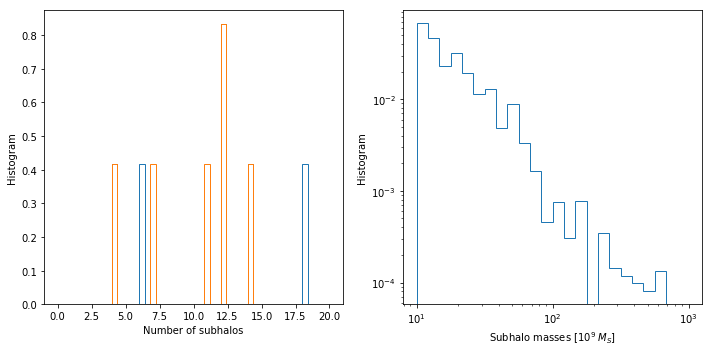

In [36]:
fig = plt.figure(figsize=(10,5))

# Number of subhalos
ax = plt.subplot(1,2,1)
plt.hist(n_subs[y==0], bins=50, range=(0,20), histtype='step', density=True)
plt.hist(n_subs[y==1], bins=50, range=(0,20), histtype='step', density=True)
plt.xlabel(r'Number of subhalos')
plt.ylabel(r'Histogram')

# Masses
ax = plt.subplot(1,2,2)
bins = 10**(np.linspace(1., 3., 25))
plt.hist(np.hstack(m_subs), bins=bins, histtype='step', density=True)
ax.set_xscale("log", nonposx='clip')
ax.set_yscale("log", nonposy='clip')
plt.xlabel(r'Subhalo masses [$10^9 \; M_S$]')
plt.ylabel(r'Histogram')

plt.tight_layout()
plt.savefig("../figures/subhalo_params.pdf")

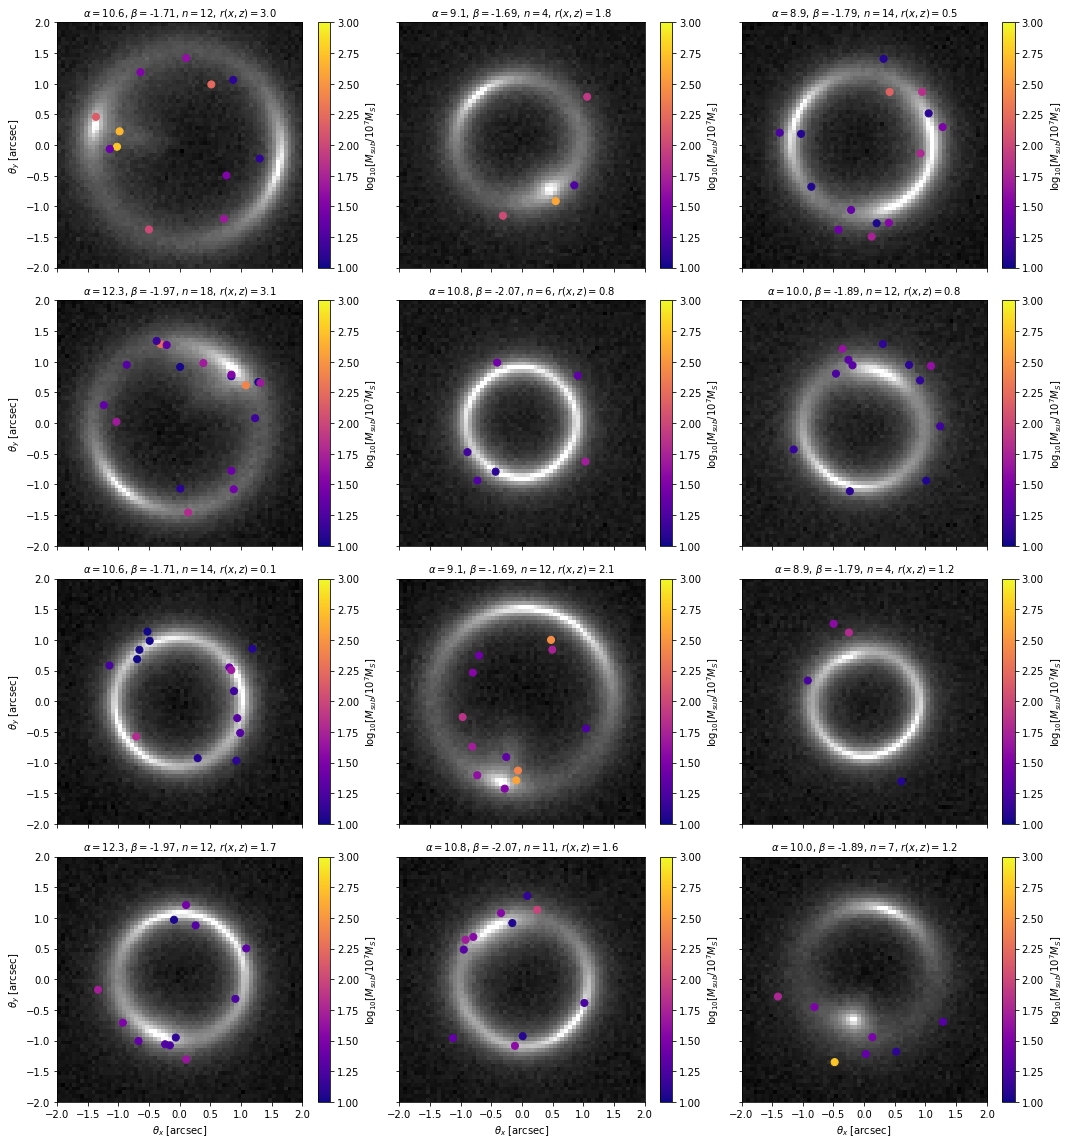

In [38]:
plt.figure(figsize=(15,16))

for i in [9,10,11,0,3,6,1,2,4,5,7,8]:
    if i == 9:
        ax_y = plt.subplot(4,3,i+1)
        ax_x = ax_y
    elif i in [10,11]:
        ax_x = plt.subplot(4,3,i+1, sharey=ax_y)
    elif i in [0,3,6]:
        ax_y = plt.subplot(4,3,i+1, sharex=ax_x)
    else:
        ax = plt.subplot(4,3,i+1, sharey=ax_y, sharex=ax_x)
        
    plt.imshow(
        np.log10(x[i]),
        vmax=3.5,
        cmap='gist_gray',
        extent=(-2.,2.,-2.,2.),
        origin="lower"
    )
    sc = plt.scatter(
        pos_subs[i][:,0],
        pos_subs[i][:,1],
        s=50.,
        c=np.log10(m_subs[i][:]),
        cmap="plasma",
        vmin=1.,
        vmax=3.,
    )
    cbar = plt.colorbar(sc)
    
    plt.xlim(-2.,2.)
    plt.ylim(-2.,2.)
    
    description = r"$\alpha = ${:.1f}, $\beta = ${:.2f}, $n = {}$, $r(x,z) = ${:.1f}".format(
            theta[i,0],
            theta[i,1],
            n_subs[i],
            r_xz[i]
        )
    plt.title(
        description,
        fontsize=10
    )
    if i in [9,10,11]:
        plt.xlabel(r"$\theta_x$ [arcsec]")
    else:
        plt.setp(plt.gca().get_xticklabels(), visible=False)
    if i in [0,3,6,9]:
        plt.ylabel(r"$\theta_y$ [arcsec]")
    else:
        plt.setp(plt.gca().get_yticklabels(), visible=False)
    cbar.set_label(r'$\log_{10} [M_{sub} / 10^7 M_S]$')
    
    
plt.tight_layout()
plt.savefig("../figures/subhalos.pdf")